In [1]:
import numpy as np
import scipy
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline

Wir wollen die vorprogrammierte SVM aus sklearn ausprobieren.
Dafür erstellen wir linear trennbare Toydaten in $mathbb{R}^2$

In [2]:
def initialize(l,n):
    data = 2*np.random.rand(l,n)-1  #create l random data points uniformly distributed over [-1,1]^n
    rand_direction = np.random.rand(n)-0.5 #direction of seperating hyperplane
    rand_transition = 0.2*np.random.random() #transition of seperating hyperplane
    labels = np.array([np.dot(i,rand_direction) > rand_transition for i in data])
    return data, labels, rand_direction, rand_transition

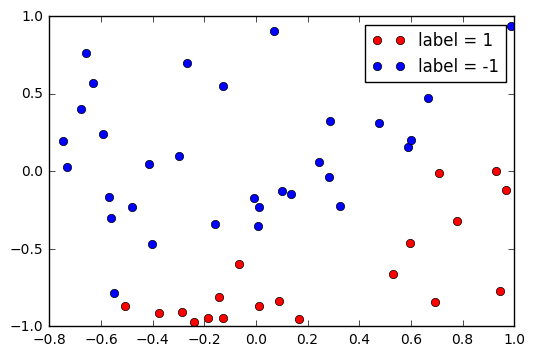

In [43]:
# fix random seed for reproducibility
seed = 2
np.random.seed(seed)
example_data, example_labels, example_rand_direction, example_rand_transition = initialize(50, 2)
example_data, example_labels, example_rand_direction, example_rand_transition
label1 = example_data[example_labels]
label0 = np.array(example_data[~example_labels])

#replace 0-labels with -1
example_labels = np.array([1 if x == True else -1 for x in example_labels])
fig1 = plt.figure()
p1, = plt.plot(label1[:,0], label1[:,1], 'ro', label = 'label = 1')
p2, = plt.plot( label0[:,0], label0[:,1], 'o', label = 'label = -1')
legend = plt.legend(handles = [p1, p2])

## Linear Kernel

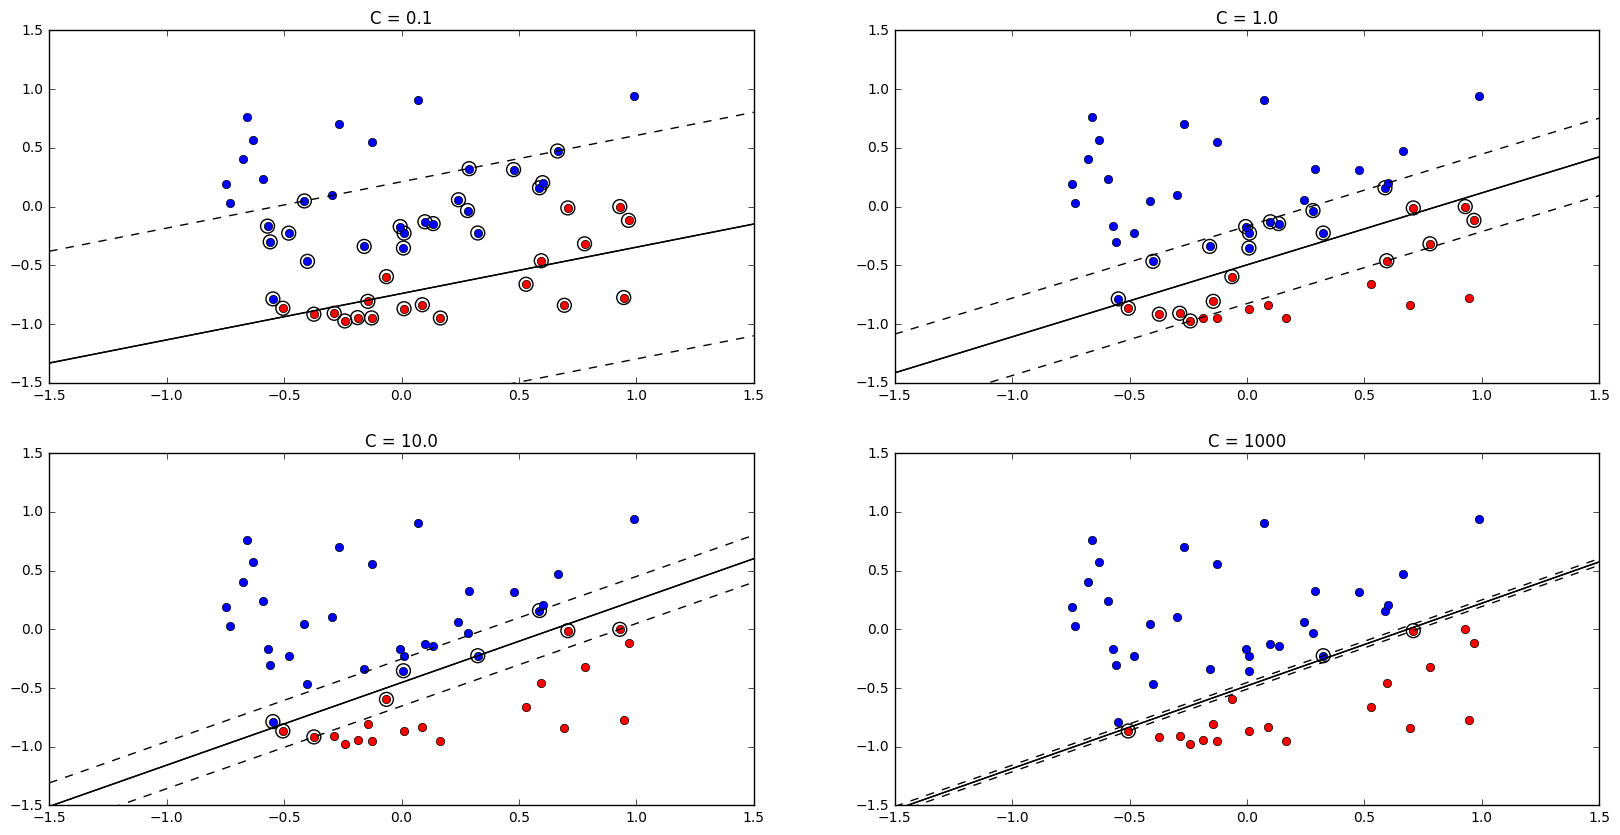

In [77]:
#get seperating hyperplane
C_list = [0.1, 1., 10., 1000]
plt_list = []
fig_linear = plt.figure(figsize=(20,10))

for i in range(4):
    C = C_list[i]
    my_svm = SVC(C=C, kernel='linear')
    my_svm.fit(example_data, example_labels)
    w = my_svm.coef_[0]
    m = -w[0] / w[1]   #Steigung der Funktionsgleichung, die die decision boundary beschreibt
    x = np.linspace(-1.5, 1.5)
    b = my_svm.intercept_[0]   #transition of hyperplane
    y = m * x - b / w[1]

    plt_list.append(fig_linear.add_subplot(221+i))
    plt_list[i].plot(x, y, 'k-')
    p1, = plt_list[i].plot(label1[:,0], label1[:,1], 'ro', label = 'label = 1')
    p2, = plt_list[i].plot( label0[:,0], label0[:,1], 'o', label = 'label = -1')

    #get margin
    margin = 1 / np.linalg.norm(w)
    lower_margin = y + np.sqrt(m**2+1)* margin
    upper_margin = y - np.sqrt(m**2+1) * margin
    plt.plot(x, y, 'k-', x, lower_margin, 'k--', x,upper_margin, 'k--')

    #get support vectors
    supp_vectors = my_svm.support_vectors_
    plt.scatter(supp_vectors[:,0], supp_vectors[:,1], s=100, facecolors = 'none')

    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.title('C = '+str(C))

Beobachtung: Großes C führt zu schmaler Margin mit wenigen Support Vektoren aber ggf Overfitting, da Trainingsdaten innerhalb der Margin hart bestraft werden.

## Gausskernel

In [71]:
def gaussian_kernel(x, y, sigma):
    return np.exp(-sigma*np.linalg.norm(x-y))

def decision_function(x, supp_vectors, atimeslabels_supp, gamma): #nur fuer Gauss-Kernel
    k = np.array([gaussian_kernel(y, x, gamma) for y in supp_vectors])
    return np.dot(atimeslabels_supp, k) + b

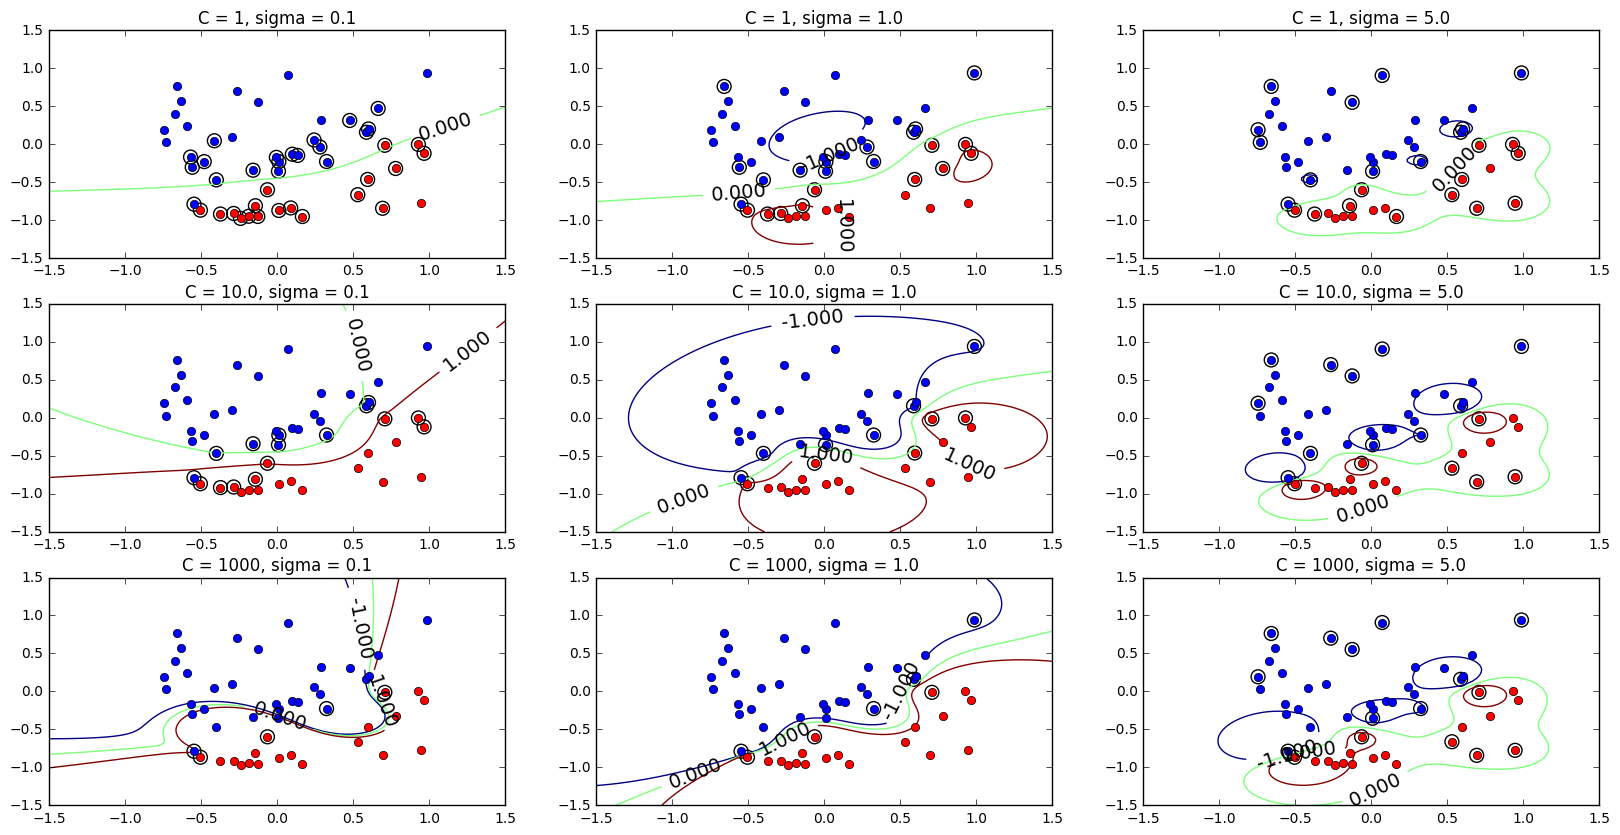

In [81]:
C_list = [1, 10., 1000]
gamma_list = [0.1, 1., 5.]
plt_list = []
fig_gauss = plt.figure(figsize=(20,10))

for i in range(len(C_list)):
    C = C_list[i]
    plt_list.append([])
    for j in range(len(gamma_list)):
        gamma = gamma_list[j]
        my_svm = SVC(C=C, kernel='rbf', gamma=gamma)
        my_svm.fit(example_data, example_labels);
        #get decision function
        atimeslabels = my_svm.dual_coef_
        b = my_svm.intercept_[0]   #transition of hyperplane
        supp_vectors = my_svm.support_vectors_
        supp_indices = my_svm.support_   #indices of support vectors
        
        x = np.linspace(-1.5, 1.5, 100)
        X, Y = np.meshgrid(x, x)
        Z = np.array([[decision_function(np.array([xi, xj]), supp_vectors, atimeslabels, gamma) for xi in x] for xj in x])
        Z = np.reshape(Z, (np.shape(Z)[0], np.shape(Z)[1]))
        
        plt_list[i].append(fig_gauss.add_subplot(331+3*i+j))        
        CS = plt_list[i][j].contour(X, Y, Z, levels = [-1, 0, 1])
        plt.clabel(CS, colors = 'k', fontsize=14)

        p1, = plt.plot(label1[:,0], label1[:,1], 'ro', label = 'label = 1')
        p2, = plt.plot( label0[:,0], label0[:,1], 'o', label = 'label = -1')
        plt.scatter(supp_vectors[:,0], supp_vectors[:,1], s=100, facecolors = 'none')
        plt.xlim([-1.5, 1.5])
        plt.ylim([-1.5, 1.5])
        plt.title('C = '+str(C) + ', sigma = ' + str(gamma))


Beobachtung: großes $\sigma$ führt zu Overfitting. Großes $C$ führt zu einer schmalen Margin mit wenigen Support Vektoren.

## Vergleich mit Pauls SMO
### Linearer Kernel

In [10]:
from smo import smo

In [11]:
def scalar_product(v1,v2):
    '''standard scalar product'''
    return np.dot(v1,v2)

In [133]:
def extract_suppvectors(alpha, data):
    supp_indices = np.array([i for i in range(len(data)) if not alpha[i]==0])
    supp_vectors = data[supp_indices]
    return supp_indices, supp_vectors

def extract_w(alpa, labels, data):
    #nur für linear kernels
    w = np.sum((np.array(alpha[i]*labels[i]*data[i]) for i in supp_indices), axis = 0)
    return w

def y_withoutb(x, alpha_supp, labels_supp, data_supp, kernel):
    alphatimeslabels = np.multiply(alpha_supp, labels_supp)
    k = np.array([kernel(x, y) for y in data_supp])
    return np.dot(alphatimeslabels, k)

def extract_b(alpha_supp, labels_supp, data_supp, kernel, C):
    indicesonmargin = np.array([i for i in range(len(data_supp)) if alpha_supp[i]<C ])
    print(data_supp[indicesonmargin])
    return 1./len(indicesonmargin)*sum([labels_supp[i]-y_withoutb(data_supp[i],alpha_supp, labels_supp, data_supp, kernel) for i in range(len(indicesonmargin))])

[[-0.41395354  0.04813375]
 [ 0.6640338   0.47349411]]
[[-0.24157887 -0.97396533]
 [ 0.59480988 -0.4612224 ]
 [-0.0058524  -0.17018833]]
[[  5.87274909e-01   1.60008358e-01]
 [  9.29102160e-01   1.67223404e-05]
 [  1.34288255e-01  -1.44908073e-01]
 [ -3.73482943e-01  -9.16404580e-01]]
[[ 0.70795059 -0.01152633]
 [-0.50564552 -0.86571126]
 [ 0.32440404 -0.22495315]]


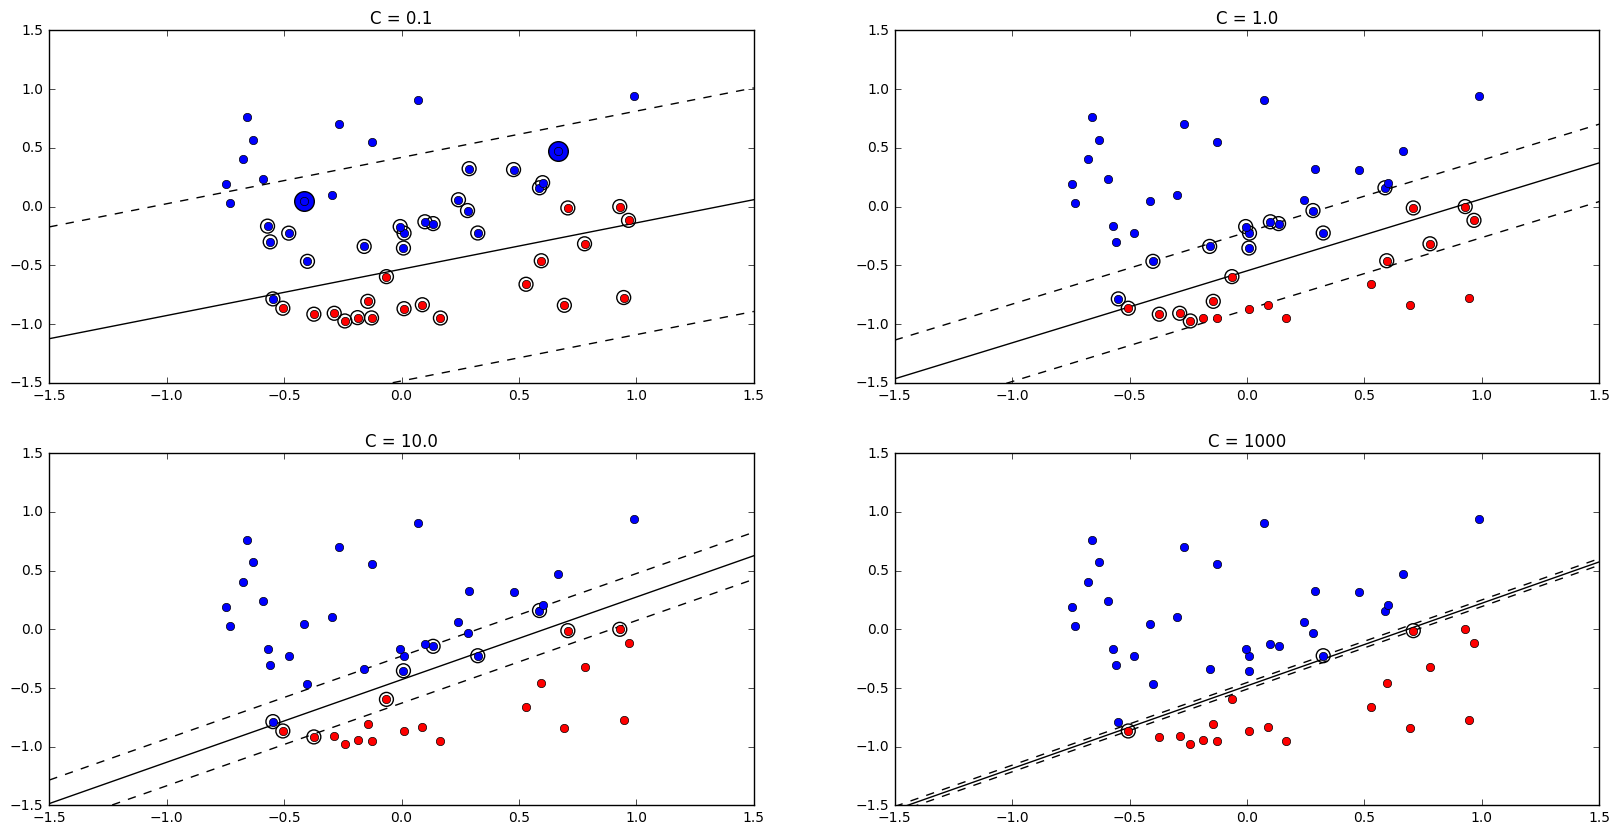

In [134]:
C_list = [0.1, 1., 10., 1000]
plt_list = []
fig_linear_Paul = plt.figure(figsize=(20,10))
x = np.linspace(-1.5, 1.5, 100)
X, Y = np.meshgrid(x, x)

for i in range(4):
    C = C_list[i]
    solution = smo(np.transpose(example_data),example_labels,C,scalar_product,1e-5,'yes', kernel_identifier='standard scalar product')
    alpha = solution['solution']
    supp_indices, supp_vectors = extract_suppvectors(alpha, example_data)
    w = extract_w(alpha, example_labels, example_data)
    b = extract_b(alpha[supp_indices], example_labels[supp_indices], supp_vectors, scalar_product, C)
    m = -w[0] / w[1]   #Steigung der Funktionsgleichung, die die decision boundary beschreibt
    x = np.linspace(-1.5, 1.5)
    y = m * x - b / w[1]
    
    #get margin
    margin = 1 / np.linalg.norm(w)
    lower_margin = y + np.sqrt(m**2+1)* margin
    upper_margin = y - np.sqrt(m**2+1) * margin
    
    plt_list.append(fig_linear_Paul.add_subplot(221+i))
    plt_list[i].plot(x, y, 'k-', x, lower_margin, 'k--', x,upper_margin, 'k--')
    p1, = plt_list[i].plot(label1[:,0], label1[:,1], 'ro', label = 'label = 1')
    p2, = plt_list[i].plot( label0[:,0], label0[:,1], 'o', label = 'label = -1')
    plt.scatter(supp_vectors[:,0], supp_vectors[:,1], s=100, facecolors = 'none')
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.title('C = '+str(C))

A = np.transpose(np.array([[-0.41395354,  0.04813375],[ 0.6640338,   0.47349411]]))#angeblich support vectoren auf dem rand der margin für C=0.1
plt_list[0].scatter(A[0], A[1], s=200)

### Gaußkernel

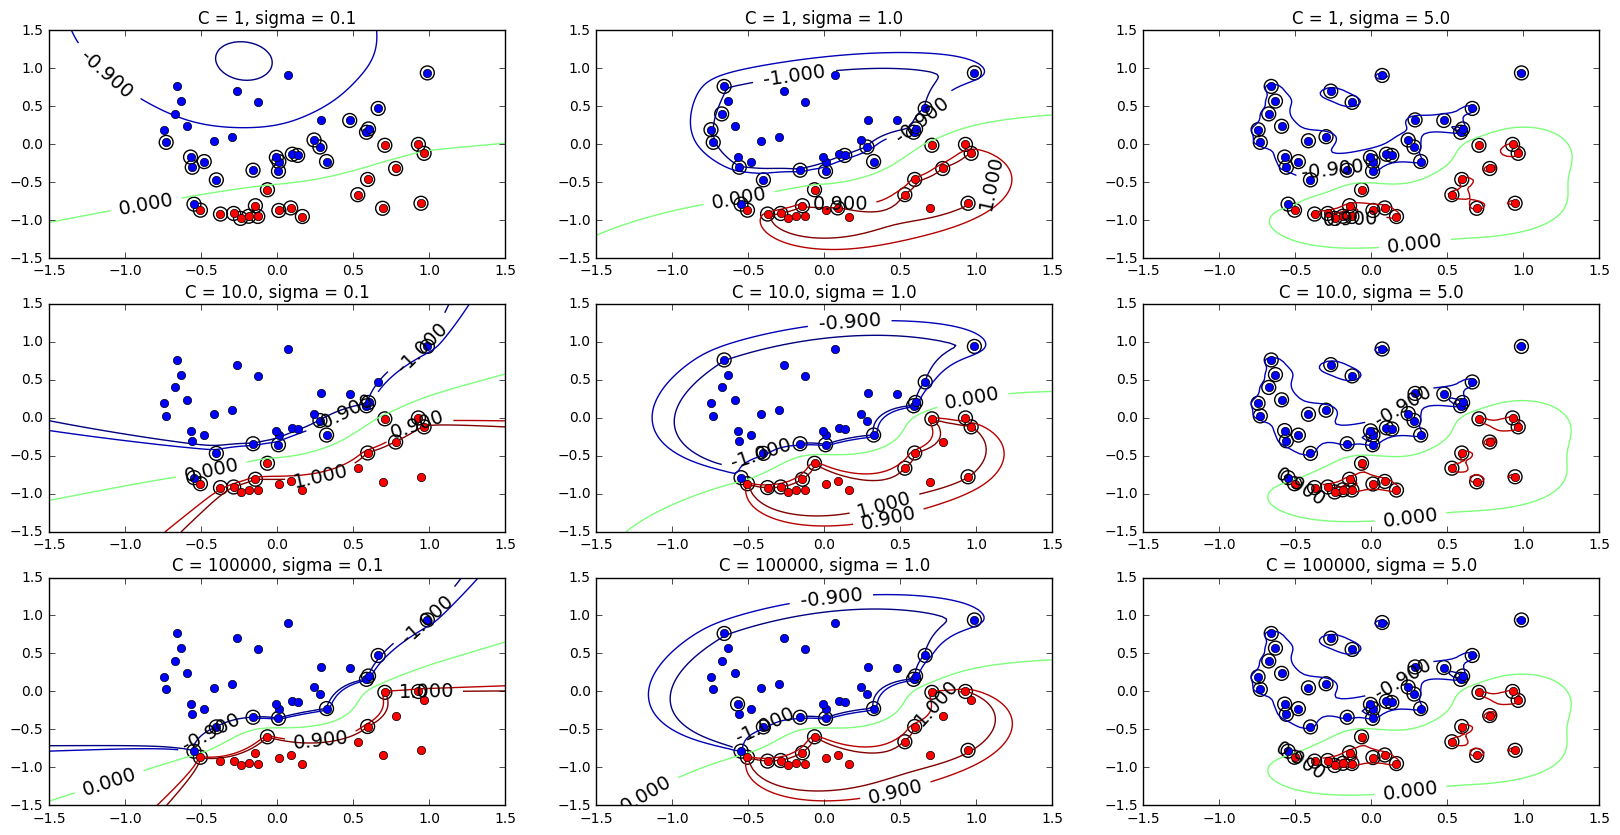

In [130]:
C_list = [1, 10., 100000]
gamma_list = [0.1, 1., 5.]
plt_list = []
fig_gauss_Paul = plt.figure(figsize=(20,10))
x = np.linspace(-1.5, 1.5, 100)
X, Y = np.meshgrid(x, x)

for i in range(len(C_list)):
    C = C_list[i]
    plt_list.append([])
    for j in range(len(gamma_list)):
        gamma = gamma_list[j]
        def kernel(x,y):
            return gaussian_kernel(x,y,gamma)
        
        solution = smo(np.transpose(example_data),example_labels,C,kernel,1e-5,'yes')
        alpha = solution['solution']
        
        #get decision function
        supp_indices, supp_vectors = extract_suppvectors(alpha, example_data) #support vectors and indices of support vectors
        atimeslabels_supp = np.multiply(alpha[supp_indices], example_labels[supp_indices])
        b = extract_b(alpha[supp_indices], example_labels[supp_indices], example_data[supp_indices], kernel, C)
        
        Z = np.array([[decision_function(np.array([xi, xj]), supp_vectors, atimeslabels_supp, gamma) for xi in x] for xj in x])
        Z = np.reshape(Z, (np.shape(Z)[0], np.shape(Z)[1]))
        
        plt_list[i].append(fig_gauss_Paul.add_subplot(331+3*i+j))        
        CS = plt_list[i][j].contour(X, Y, Z, levels = [-1, -0.9, 0, .9, 1])
        plt.clabel(CS, colors = 'k', fontsize=14)

        p1, = plt.plot(label1[:,0], label1[:,1], 'ro', label = 'label = 1')
        p2, = plt.plot( label0[:,0], label0[:,1], 'o', label = 'label = -1')
        plt.scatter(supp_vectors[:,0], supp_vectors[:,1], s=100, facecolors = 'none')
        plt.xlim([-1.5, 1.5])
        plt.ylim([-1.5, 1.5])
        plt.title('C = '+str(C) + ', sigma = ' + str(gamma))


## SVM mit Pauls SMO als Klasse

In [98]:
def assemble_kernelmatrix(data, data2 = None, kernel = scalar_product):
    if data2 == None:
        K = pairwise_kernels(data, metric = kernel)
    else:
        K = pairwise_kernels(data2, data, metric = kernel)
    return K

In [99]:
class mySVM:
    
    def __init__(self, kernel = gaussian_kernel, penalty = 1, sigma = 0.01):
        self.sigma = sigma
        self.kernel = kernel
        self.penalty = penalty
        self.kernelmatrix_for_predict = None
        self.tolerance = 1e-5
        
    def fit(self,training_data, training_labels):
        kernel_identifier = None
        if self.kernel == gaussian_kernel:
            def kernel_sigma(x, y):
                return gaussian_kernel(x, y, self.sigma)
            self.kernel = kernel_sigma
        if self.kernel == scalar_product:
            kernel_identifier = 'standard scalar product'
        solution = smo(np.transpose(training_data),training_labels,self.penalty,self.kernel,self.tolerance,'yes', kernel_identifier)
        self.alpha = solution['solution']
        self.training_data = training_data
        self.training_labels = training_labels
        self.supp_indices, self.supp_vectors = extract_suppvectors(alpha, example_data) #support vectors and indices of support vectors
        self.b = extract_b(self.alpha[self.supp_indices], training_labels[self.supp_indices], self.supp_vectors, self.kernel, self.penalty)
        if self.kernel == scalar_product:
            self.w = extract_w(self.alpha, training_labels, training_data)
        
    def predict(self, newdata):
        if self.kernelmatrix_for_predict == None:
            self.kernelmatrix_for_predict = assemble_kernelmatrix(self.training_data, data2 = newdata, kernel = self.kernel)
        k = self.kernelmatrix_for_predict
        alphatimeslabel = np.multiply(self.alpha[self.supp_indices], self.supp_vectors)
        prediction = np.array([np.dot(k[i,:], alphatimeslabel) for i in range(len(newdata))])
        return np.sign(prediction)
    
        

In [127]:
svm = mySVM()
svm.fit(example_data, example_labels)
#svm.predict

IndexError: arrays used as indices must be of integer (or boolean) type

In [94]:
g = gaussian_kernel
g== gaussian_kernel

True